#### This notebook is derived from Simon's make_present_day_environments.ipynb
#### The purpose of this notebook is to create present day paleogeography features, so that we can generate paleotopography grids from 0Ma to 6Ma.
#### The idea is to polygonise the present-day topography grid. 
* option 1: from skimage import measure ; contours = measure.find_contours(...)
* option 2: gdal_polygonize.py

#### load present-day topography grid

Failed to load plotting dependencies


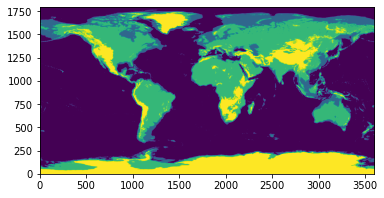

In [1]:
import sys, os
sys.path.insert(0,'../paleogeography')
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import paleogeography as pg
# load global topography

gridX,gridY,gridZ = pg.load_netcdf('./topo15_3600x1800.nc')
#gridX,gridY,gridZ = pg.load_netcdf('/Users/Simon/Data/SedThickness/GEBCO1m/test.nc')
#gridX,gridY,gridZ = pg.load_netcdf('/Users/Simon/Data/GMTdata/hawaii2017/earth_relief_10m.grd')

# gdal complains if latitudes are outside 90 degrees, so remove top and bottom rows
gridZ = gridZ[1:-1,:]
gridY = gridY[1:-1]

# make a grid of zeros, then replace values by incrementally increasinf integers for each higher level of topography
tmp = np.zeros(gridZ.shape)
tmp[gridZ>-500] = 1
tmp[gridZ>0] = 2
tmp[gridZ>1000] = 3

plt.imshow(tmp,origin='lower')


#### polygonise the present-day topography grid and save the polygons

In [7]:
import pygplates
# write the integer category grid to a file
ds = xr.DataArray(tmp,
                  coords=[('lat',gridY),('lon',gridX)])
ds.to_netcdf('./present_day_topo_as_classes.nc',format='NETCDF3_CLASSIC')

# use gdal polygonise to create polygons mapping the categories
os.system('gdal_polygonize.py ./present_day_topo_as_classes.nc -f "GMT" . tmp DN')

features = pygplates.FeatureCollection('tmp.gmt')

pg_features = []

for feature in features:
    #if feature.get_shapefile_attribute('DN')==0:
    #    feature.set_shapefile_attribute('Layer','do')
    if feature.get_shapefile_attribute('DN')==1:
        feature.set_shapefile_attribute('Layer','sm')
        pg_features.append(feature)
    elif feature.get_shapefile_attribute('DN')==2:
        feature.set_shapefile_attribute('Layer','lm')
        pg_features.append(feature)
    elif feature.get_shapefile_attribute('DN')==3:
        feature.set_shapefile_attribute('Layer','m')
        pg_features.append(feature)
    #else:
    #    feature.set_shapefile_attribute('Layer','')

pygplates.FeatureCollection(pg_features).write('./present_day_paleogeography.gmt')#save the data

with open('./present_day_paleogeography.gmt','r') as f:
    print(f.read()[:1000])#print some of the data in created file


# @VGMT1.0 @GMULTIPOLYGON
# @R-179.997916667/179.997916667/-89.9020810185/86.1019930556             
# @Je4326
# @Jp"+proj=longlat +datum=WGS84 +no_defs"
# @Jw"GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]]"
# @NDN|Layer|PLATEID1|FROMAGE|TOAGE|NAME|DESCR|PLATEID2|GPGIM_TYPE|FEATURE_ID|RECON_METH|L_PLATE|R_PLATE|SPREAD_ASY|IMPORT_AGE
# @Tinteger|string|integer|double|double|string|string|integer|string|string|string|integer|integer|double|double
# FEATURE_DATA
>
# @D1|sm||999|-999||||gpml:UnclassifiedFeature|GPlates-73ec2b34-3036-45c4-ba21-b4c5d24d4667|||||
# @P
-53.6006203703704 86.1019930555555
-53.6006203703704 86.0019907407407
-53.500619212963 86.0019907407407
-53.500619212963 86.1019930555555
-53.